#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [41]:
import os
import re
import sys
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from skimpy import skim

warnings.filterwarnings("ignore")


-------------------------------------------------------
### Import data

In [42]:

data_dir = "/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data/clean"
path = os.path.join(data_dir,'airbnb_barcelona.csv') 
data = pd.read_csv(path)


In [43]:
data.columns

Index(['id', 'scrape_id', 'source', 'host_id', 'host_name', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood',
       ...
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object', length=266)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19455 entries, 0 to 19454
Columns: 266 entries, id to reviews_per_month
dtypes: bool(1), float64(21), int64(225), object(19)
memory usage: 39.4+ MB


In [45]:
data.view.value_counts()

view
1    14720
0     4735
Name: count, dtype: int64

In [46]:
import pandas as pd

# Define keyword-based mapping
property_mappings = {
    "Apartment": ["rental unit", "condo", "loft"],
    "House": ["home", "townhouse", "vacation home", "guesthouse", "chalet", "cabin", "bungalow", "villa", "cottage"],
    "Hotel/Serviced Stay": ["hotel", "serviced apartment", "boutique hotel", "bed and breakfast", "guest suite", "pension", "resort"],
    "Hostel": ["hostel"],
    "Traditional Stay": ["casa particular", "ryokan", "minsu"],
    "Alternative Stay": ["camper", "rv", "tiny home", "tent", "yurt", "cave", "dome", "barn", "earthen home", "religious building", "hut", "floor"],
    "Unknown": ["shared room", "entire place", "private room"],  # General category for shared spaces
}

# Function to assign property category
def categorize_property(property_type):
    property_type = str(property_type).lower()  # Ensure lowercase for comparison
    for category, keywords in property_mappings.items():
        if any(keyword in property_type for keyword in keywords):
            return category
    return "Unknown"  # Default category if no match is found

# Apply mapping function
data["property_category"] = data["property_type"].apply(categorize_property)

# Display the updated categories
property_category_counts = data["property_category"].value_counts()
print("Property Category Counts:\n", property_category_counts)

# Check remaining "Unknown" values
print("Property types classified as 'Unknown':")
print(data[data["property_category"] == "Unknown"]["property_type"].value_counts().head(20))

Property Category Counts:
 property_category
Apartment              17242
Hotel/Serviced Stay     1314
House                    431
Hostel                   339
Traditional Stay          67
Alternative Stay          32
Unknown                   30
Name: count, dtype: int64
Property types classified as 'Unknown':
property_type
Private room            20
Boat                     5
Entire place             3
Private room in boat     2
Name: count, dtype: int64


------------------------------------------------

In [47]:
# Extract Room Type (Entire, Private, Shared)
data["f_room_type"] = data["property_type"].str.extract(r"^(Entire|Private room|Shared room)")
# Fill missing values with "Unknown" before mapping
data["f_room_type"].fillna("Unknown", inplace=True)
print(data["f_room_type"].value_counts())

f_room_type
Entire          11622
Private room     6952
Unknown           704
Shared room       177
Name: count, dtype: int64


Room type as factor

In [48]:

data["f_property_type"] = data["property_category"].astype("category")
data["f_room_type"] = data["f_room_type"].astype("category")
data["f_room_type2"] = data["f_room_type"].map(
    {
        "Entire": "Entire/Apt",
        "Private room": "Private",
        "Shared room": "Shared",
        "Unknown": "Unknown"
    }
)
data["f_neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")

---------

### Create Numerical variables

In [49]:
data.columns.to_list()

['id',
 'scrape_id',
 'source',
 'host_id',
 'host_name',
 'host_since',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'license',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'body_soap',
 'condi

In [50]:
data["usd_price_day"] = data["price"]
data["p_host_response_rate"] = data["host_response_rate"].fillna(0).astype(int)
numericals = [
    "accommodates",
    "bathrooms",
    "review_scores_rating",
    "number_of_reviews",
    "reviews_per_month",
    "minimum_nights",
    "beds",
]
for col in numericals:
    data["n_" + col] = pd.to_numeric(data[col], errors="coerce")

Create days since first review

In [51]:
data["n_days_since"] = (
    data.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - data.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

data["n_days_since"] = np.where(data.first_review.isnull(), np.nan, data.n_days_since)


Create dummy vars

In [81]:
data.columns.to_list()

['f_room_type',
 'f_property_type',
 'f_room_type2',
 'f_neighbourhood_cleansed',
 'usd_price_day',
 'p_host_response_rate',
 'n_accommodates',
 'n_bathrooms',
 'n_review_scores_rating',
 'n_number_of_reviews',
 'n_reviews_per_month',
 'n_minimum_nights',
 'n_beds',
 'n_days_since',
 'd_body_soap',
 'd_conditioner',
 'd_refrigerator',
 'd_shampoo',
 'd_1_day_a_week_included_with_your_stay',
 'd_2_5_years_old',
 'd_4_days_a_week_included_with_your_stay',
 'd_5_10_years_old',
 'd_ac_split_type_ductless_system',
 'd_airplay',
 'd_and_10_years_old',
 'd_and_5_10_years_old',
 'd_and_ps3',
 'd_apple',
 'd_arcade_games',
 'd_avena',
 'd_backyard',
 'd_baking_sheet',
 'd_bar',
 'd_barbecue_utensils',
 'd_bathtub',
 'd_beach_access_beachfront',
 'd_beach_essentials',
 'd_bed_linens',
 'd_bidet',
 'd_bikes',
 'd_blender',
 'd_board_games',
 'd_boat_slip',
 'd_books_and_reading_material',
 'd_bowling_alley',
 'd_bread_maker',
 'd_breakfast',
 'd_building_staff',
 'd_candy_fcs100x_e_horno_el_ctric

In [53]:
data.columns.get_loc("shared_ameneties")


252

In [54]:
dummies = data.columns[47:254]

Rename colunms

In [55]:
for col in dummies:
    data["d_" + (re.sub("/|\s|-", "", col)).replace("(s)", "s").lower()] = data[col]


Keep columns if contain d_, n_,f_, p_, usd_ and some others

In [56]:
data = pd.concat(
    [
        data.filter(
            regex="^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*",
        ),
        data[
            [
                "price",
                "host_id",
                "neighbourhood_cleansed",
                "room_type",
                "property_type",
            ]
        ],
    ],
    axis=1,
)


### Take a look at price

In [57]:
#WHYYYYY DID HE FILTER FOR PRICE IF ITS OUR Y??? 

#data = data.loc[lambda x: x["price"] < 1000]


In [58]:
skim(data["price"].to_frame())

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 19455  │ │ float64     │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA     ┃ NA %     ┃ mean     ┃ sd       ┃ p0   ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ price            │   3895 │    20.02 │    107.3 │    91.38 │    5 │    52 │    88 │  129 │   999 │   ▇▁    │  │
│ └──────────────────┴────────┴──────────┴──────────┴──────────┴──────┴───────┴───────┴──────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<Axes: >

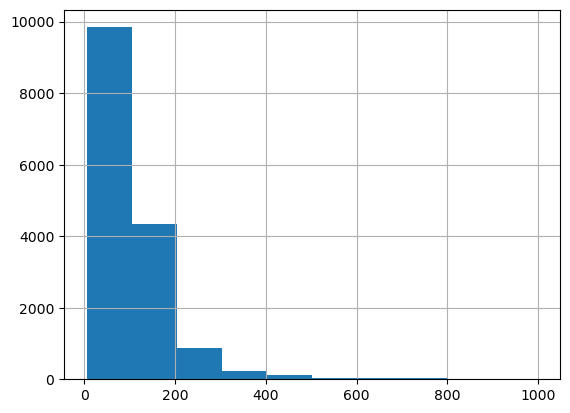

In [59]:
data["price"].hist()

<Axes: >

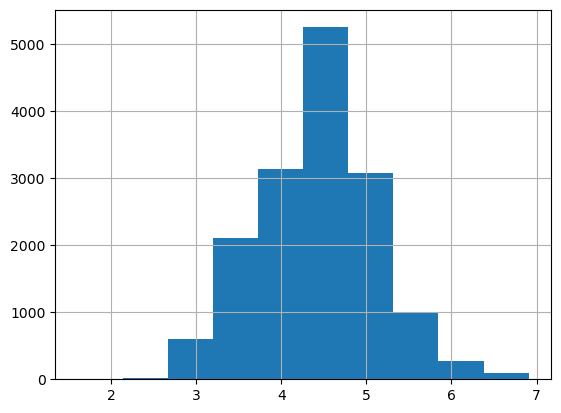

In [60]:
data["price"].apply(np.log).hist()

Squares and further values to create

In [61]:
data = data.assign(
    n_accommodates2=lambda x: x["n_accommodates"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)


 Pool accomodations with 0,1,2,10 bathrooms

In [62]:
#creating a category for bathrooms 
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 10)], closed="left")
f_bath = pd.cut(data["n_bathrooms"], bins=bins, labels=[0, 1, 2])
data["f_bathroom"] = f_bath
print(data["f_bathroom"].value_counts(dropna=False))

f_bathroom
[1.0, 2.0)     10575
[2.0, 10.0)     4773
NaN             3776
[0.0, 1.0)       331
Name: count, dtype: int64


Pool num of reviews to 3 categories: none, 1-51 and >51

In [63]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(data["n_number_of_reviews"]))], closed="left")
fnor = pd.cut(data["n_number_of_reviews"], bins=bins, labels=[0, 1, 2])
data["f_number_of_reviews"] = fnor
print(data["f_number_of_reviews"].value_counts(dropna=False))

f_number_of_reviews
[1.0, 51.0)       9707
[0.0, 1.0)        4990
[51.0, 2896.0)    4757
NaN                  1
Name: count, dtype: int64


Pool and categorize the number of minimum nights: 1,2,3, 3+

In [64]:
print("Max n_minimum_nights:", data["n_minimum_nights"].max())
print("Summary Statistics:\n", data["n_minimum_nights"].describe())
print("Unique values in n_minimum_nights:", data["n_minimum_nights"].unique())
#i assume those 3 extra values are outliers, so i will remove them
data = data[data["n_minimum_nights"] < 365] 

Max n_minimum_nights: 1124
Summary Statistics:
 count    19455.000000
mean        15.510100
std         30.487162
min          1.000000
25%          1.000000
50%          3.000000
75%         31.000000
max       1124.000000
Name: n_minimum_nights, dtype: float64
Unique values in n_minimum_nights: [   1    3   31    5    2    4    6   15  120   32   90    7   30   60
  300  180   28   21   14   40   13   20   45   50   35  179    8   10
   33   24   25   29 1124  100   75  865  360  900    9   61   70   80
  210   76   42  365   18   36  150  500   62  310  250   64 1000   66
   12   47   16   58   34  200   92   22  351  364   91  330   26   99
  122   81  115  121   27]


In [65]:
bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(data.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(data["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
data["f_minimum_nights"] = f_min_n
data["f_minimum_nights"].value_counts(dropna=False)

f_minimum_nights
[3.0, 364.0)    11026
[1.0, 2.0)       6120
[2.0, 3.0)       2280
NaN                 1
Name: count, dtype: int64

Change Infinite values with NaNs

In [66]:
data = data.replace([np.inf, -np.inf], np.nan)

___

Where do we have missing variables now?

In [67]:
data.isnull().sum().loc[lambda x: x > 0]

usd_price_day             3871
n_bathrooms               3745
n_review_scores_rating    4972
n_reviews_per_month       4972
n_beds                    3823
n_days_since              4972
price                     3871
ln_beds                   4135
f_bathroom                3752
f_number_of_reviews          1
f_minimum_nights             1
dtype: int64

What to do with missing values?

1. drop if no target

In [68]:
data = data.loc[lambda x: x["price"].notnull()]

2. imput when few, not that important

In [69]:
# Ensure 'n_accommodates' has no missing values before using it in 'n_beds'
data["n_accommodates"] = data["n_accommodates"].fillna(data["n_accommodates"].median())

# Fix categorical columns by adding "99" as a category before filling NaNs
for col in ["f_bathroom", "f_minimum_nights", "f_number_of_reviews"]:
    if col in data.columns and pd.api.types.is_categorical_dtype(data[col]):
        data[col] = data[col].cat.add_categories([99]).fillna(99)  # Add category & fill NaNs
    else:
        data[col] = data[col].fillna(99)  # If not categorical, fill normally

# Assign and fill missing values in a single step
data = data.assign(
    n_bathrooms=lambda x: x["n_bathrooms"].fillna(np.median(x["n_bathrooms"].dropna())),
    n_beds=lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    ln_beds=lambda x: x["ln_beds"].fillna(0),
)

In [70]:
data.isnull().sum().loc[lambda x: x > 0]

n_review_scores_rating    3389
n_reviews_per_month       3389
n_days_since              3389
dtype: int64

 4. Replace missing variables re reviews with zero, when no review + add flags

In [71]:
data = data.assign(
    flag_days_since=np.multiply(data["n_days_since"].isnull(), 1),
    n_days_since=data["n_days_since"].fillna(np.median(data["n_days_since"].dropna())),
    flag_review_scores_rating=np.multiply(data["n_review_scores_rating"].isnull(), 1),
    n_review_scores_rating=data["n_review_scores_rating"].fillna(
        np.median(data["n_review_scores_rating"].dropna())
    ),
    flag_reviews_per_month=np.multiply(data["n_reviews_per_month"].isnull(), 1),
    n_reviews_per_month=data["n_reviews_per_month"].fillna(
        np.median(data["n_reviews_per_month"].dropna())
    ),
    flag_n_number_of_reviews=np.multiply(data["n_number_of_reviews"].isnull(), 1),
)

In [72]:
data.flag_days_since.value_counts()


flag_days_since
0    12167
1     3389
Name: count, dtype: int64


Redo features

Create variables, measuring the time since: squared, cubic, logs

In [ ]:
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)


In [74]:
data["n_days_since"] = data["ln_days_since"].fillna(0)
data["ln_days_since2"] = data["ln_days_since2"].fillna(0)
data["ln_days_since3"] = data["ln_days_since3"].fillna(0)

In [75]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

In [76]:
data.describe()


,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,15556.000000,15556.0,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,...,15556.000000,15556.000000,15556.000000,15556.0,15556.000000,15556.000000,15556.000000,1.555600e+04,1.555600e+04,15556.000000
mean,107.328619,0.0,3.557855,1.392774,4.617769,57.320262,1.524343,14.636218,2.431859,6.661322,...,0.217858,0.217858,0.217858,0.0,6.661322,45.802169,322.260899,2.922589e+06,8.683411e+09,1.522668
std,91.383984,0.0,2.184498,0.713292,0.444167,111.626984,1.921227,18.186318,2.080365,1.195430,...,0.412804,0.412804,0.412804,0.0,1.195430,14.508133,140.048712,4.569842e+06,1.819749e+10,0.137897
min,5.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.693147,...,0.000000,0.000000,0.000000,0.0,0.693147,0.480453,0.333025,1.000000e+00,1.000000e+00,0.000000
25%,52.000000,0.0,2.000000,1.000000,4.540000,1.000000,0.420000,1.000000,1.000000,6.200509,...,0.000000,0.000000,0.000000,0.0,6.200509,38.446314,238.386723,2.420640e+05,1.190955e+08,1.512927
50%,88.000000,0.0,3.000000,1.000000,4.710000,10.000000,1.020000,3.000000,2.000000,6.826545,...,0.000000,0.000000,0.000000,0.0,6.826545,46.601720,318.128747,8.482410e+05,7.812300e+08,1.549688
75%,129.000000,0.0,5.000000,2.000000,4.840000,66.000000,2.000000,31.000000,3.000000,7.556559,...,0.000000,0.000000,0.000000,0.0,7.556559,57.101578,431.491424,3.656700e+06,6.992526e+09,1.576915
max,999.000000,0.0,16.000000,9.000000,5.000000,2896.000000,80.220000,360.000000,127.000000,8.569786,...,1.000000,1.000000,1.000000,0.0,8.569786,73.441226,629.375564,2.776236e+07,1.462799e+11,1.609438


In [77]:
#skim(data)

In [78]:
data.to_csv("data/barcelona_workfile.csv", index=False)

In [79]:
data.d_view.value_counts()

d_view
1    12364
0     3192
Name: count, dtype: int64

In [80]:
data.d_airconditioning.value_counts()

d_airconditioning
1    10603
0     4953
Name: count, dtype: int64